# Example of FedAvg and FedProx for two datasets: MNIST iid and MNIST non-iid



In [1]:
! curl -o create_MNIST_datasets.py "https://gitlab.inria.fr/epione/flhd/-/raw/master/federated_learning/create_MNIST_datasets.py?inline=false"
! curl -o create_synthetic_MNIST_datasets.py "https://gitlab.inria.fr/epione/flhd/-/raw/master/federated_learning/create_synthetic_MNIST_datasets.py?inline=false"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  3432  100  3432    0     0  10982      0 --:--:-- --:--:-- --:--:-- 11179
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  7921  100  7921    0     0  29204      0 --:--:-- --:--:-- --:--:-- 29778


## 1. MNIST iid

### Data loading and visualization

First of all, we load the train and test MNIST dataset and randomly split them in 3 non-overlapping datasets. We will use them for the 3 different nodes.

In [ ]:
from create_MNIST_datasets import get_MNIST, plot_samples
mnist_iid_train_dls, mnist_iid_test_dls = get_MNIST("iid",
    n_samples_train =200, n_samples_test=100, n_clients =3, 
    batch_size =25, shuffle =True)

In the following cell we plot some samples from the 3 datasets

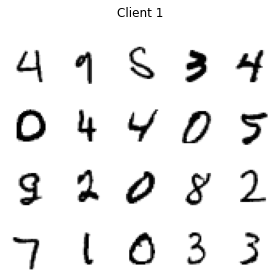

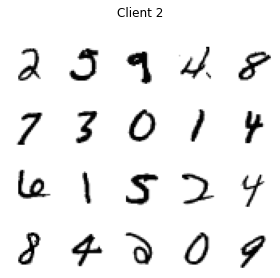

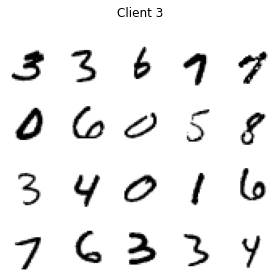

In [3]:
plot_samples(next(iter(mnist_iid_train_dls[0])), 0, "Client 1")
plot_samples(next(iter(mnist_iid_train_dls[1])), 0, "Client 2")
plot_samples(next(iter(mnist_iid_train_dls[2])), 0, "Client 3")

As you can see, all the digits are represented in each client. Indeed we split the dataset so to have independent and identically distributed (iid) samples.

### Classification

We define a convolutional neural network (CNN) for digits classification. We also define the functions for training, and for computing loss and accuracy.

In [4]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet -> 
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

model_0 = CNN()

In [5]:
def loss_classifier(predictions,labels):
    
    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")
    
    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0
    
    for idx,(features,labels) in enumerate(dataset):
        
        predictions= model(features)
        loss+=loss_f(predictions,labels)
    
    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""
    
    correct=0
    
    for features,labels in iter(dataset):
        
        predictions= model(features)
        
        _,predicted=predictions.max(1,keepdim=True)
        
        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()
        
    accuracy = 100*correct/len(dataset.dataset)
        
    return accuracy


def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""
    
    total_loss=0
    
    for idx, (features,labels) in enumerate(train_data):
        
        optimizer.zero_grad()
        
        predictions= model(features)
        
        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss
        
        loss.backward()
        optimizer.step()
        
    return total_loss/(idx+1)



def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):
    
    model_0=deepcopy(model)
    
    for e in range(epochs):
        local_loss=train_step(model,model_0,mu,optimizer,train_data,loss_f)
        
    return float(local_loss.detach().numpy())


def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    
    tensor_1=list(model_1.parameters())
    tensor_2=list(model_2.parameters())
    
    norm=sum([torch.sum((tensor_1[i]-tensor_2[i])**2) 
        for i in range(len(tensor_1))])
    
    return norm


def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)
        

### Aggregation strategies

Federated learning requires to define an aggregation strategy, i.e. a method to combine the local models coming from the clients into a global one.

**Federated averaging**

The standard and simplest aggregation strategy is federated averaging ([FedAvg](https://arxiv.org/pdf/1602.05629.pdf)).

The learning is performed in rounds. At each round, the server samples a set of $m$ clients (out of the total $K$ clients) which will be considered for the current iteration and sends them the current global model.
These clients update the parameters of their local copy of the model by optimizing the loss $F_k$ on their local training data using SGD for $E$ epochs. At the end of the round, the local parameters are sent to the server, which aggregates them by performing a weighted average. The aggregated parameters define the global model for the next round.

**FedProx**

Another strategy is [FedProx](https://arxiv.org/pdf/1812.06127.pdf), which is a generalization of FedAvg with some modifications to address heterogeneity of data and systems.

The learning is again performed in rounds. At each round, the server samples a set of $m$ clients and sends them the current global model.
Differently from FedAvg, here the clients optimize a regularized loss with a proximal term. In particular, the new function to minimize is $F_k(\omega) + \frac{\mu}{2}||\omega - \omega^t ||^2$, where $F_k$ is the loss, $\omega$ are the local parameter to optimize, and $\omega^t$ are the global parameters at time $t$.   
Moreover we run the local optimization for a variable number of epochs according to the system resources (so that slow clients can also contribute to the training with a reduced number of epochs). 
As for FedAvg, the local parameters are sent to the server and aggregated.

**NOTE** FedAvg is a particular case of FedProx with $\mu=0$. So, we just need to implement the code for FedProx, which we will be used also for FedAvg by setting the parameter *mu=0*

In [6]:
def average_models(model, clients_models_hist:list , weights:list):


    """Creates the new model of a given iteration with the models of the other
    clients"""
    
    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):
        
        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)
            
    return new_model

In [7]:
def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0, 
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the 
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration
    
    returns :
        - `model`: the final global model 
    """
        
    loss_f=loss_classifier
    
    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)
    
    
    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach()) 
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy() 
        for tens_param in list(model.parameters())]]
    models_hist = []
    
    
    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')
    
    for i in range(n_iter):
        
        clients_params=[]
        clients_models=[]
        clients_losses=[]
        
        for k in range(K):
            
            local_model=deepcopy(model)
            local_optimizer=optim.SGD(local_model.parameters(),lr=lr)
            
            local_loss=local_learning(local_model,mu,local_optimizer,
                training_sets[k],epochs,loss_f)
            
            clients_losses.append(local_loss)
                
            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)    
            clients_models.append(deepcopy(local_model))
        
        
        #CREATE THE NEW GLOBAL MODEL
        model = average_models(deepcopy(model), clients_params, 
            weights=weights)
        models_hist.append(clients_models)
        
        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach()) 
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')
        

        server_hist.append([tens_param.detach().cpu().numpy() 
            for tens_param in list(model.parameters())])
        
        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay
            
    return model, loss_hist, acc_hist

### Federated training with FedAvg

We will now train the model on the 3 clients, using FedAvg aggregation strategy.

**NOTE** In this notebook, during the training, we will consider the 3 clients for each round ($m=K=3$)

In [8]:
# Train with FedAvg -> FedProx with mu=0

n_iter=10

model_f, loss_hist_FA_iid, acc_hist_FA_iid = FedProx( model_0, 
    mnist_iid_train_dls, n_iter, mnist_iid_test_dls, epochs =2, 
    lr =0.1, mu=0)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3034559885660806 Server Test Accuracy: 12.666666666666666
====> i: 1 Loss: 2.2008462746938067 Server Test Accuracy: 45.33333333333333
====> i: 2 Loss: 1.612090229988098 Server Test Accuracy: 67.0
====> i: 3 Loss: 0.8298508524894713 Server Test Accuracy: 76.66666666666666
====> i: 4 Loss: 0.6663561264673868 Server Test Accuracy: 80.33333333333333
====> i: 5 Loss: 0.3911072413126627 Server Test Accuracy: 85.0
====> i: 6 Loss: 0.2968725264072418 Server Test Accuracy: 88.33333333333333
====> i: 7 Loss: 0.25774654746055603 Server Test Accuracy: 88.33333333333333
====> i: 8 Loss: 0.186477725704511 Server Test Accuracy: 88.66666666666666
====> i: 9 Loss: 0.1560917297999064 Server Test Accuracy: 91.0
====> i: 10 Loss: 0.15153571963310242 Server Test Accuracy: 90.66666666666666


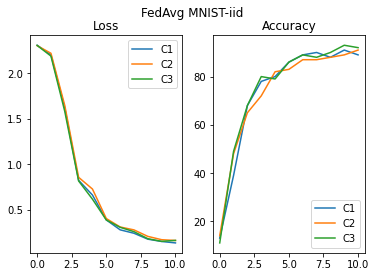

In [9]:
def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
    plt.figure()
    
    plt.suptitle(title)

    plt.subplot(1,2,1)
    lines=plt.plot(loss_hist)
    plt.title("Loss")
    plt.legend(lines,["C1", "C2", "C3"])

    plt.subplot(1,2,2)
    lines=plt.plot(acc_hist )
    plt.title("Accuracy")
    plt.legend(lines, ["C1", "C2", "C3"])
    

plot_acc_loss("FedAvg MNIST-iid", loss_hist_FA_iid, acc_hist_FA_iid)

### Federated training with FedProx

We will now train the model on the 3 clients, using FedProx aggregation strategy.

**NOTE** We are going to consider the 3 clients in every round ($m=K=3$) and we assume that they have the same system resources (they will run the same number of epochs each round)

In [10]:
# Train with FedProx, mu=0.3

n_iter=10

model_f, loss_hist_FP_iid, acc_hist_FP_iid = FedProx( model_0, 
    mnist_iid_train_dls, n_iter, mnist_iid_test_dls, 
    epochs =2, lr =0.1, mu =.3)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3034561475118 Server Test Accuracy: 12.666666666666666
====> i: 1 Loss: 2.2242785294850664 Server Test Accuracy: 45.0
====> i: 2 Loss: 1.8722834587097168 Server Test Accuracy: 63.666666666666664
====> i: 3 Loss: 1.2192330757776895 Server Test Accuracy: 68.0
====> i: 4 Loss: 0.7412361105283101 Server Test Accuracy: 74.0
====> i: 5 Loss: 0.5382228692372639 Server Test Accuracy: 81.66666666666666
====> i: 6 Loss: 0.4193421006202698 Server Test Accuracy: 87.0
====> i: 7 Loss: 0.37521087129910785 Server Test Accuracy: 81.66666666666666
====> i: 8 Loss: 0.2531132847070694 Server Test Accuracy: 88.0
====> i: 9 Loss: 0.24042304853598276 Server Test Accuracy: 88.0
====> i: 10 Loss: 0.1759762366612752 Server Test Accuracy: 90.33333333333333


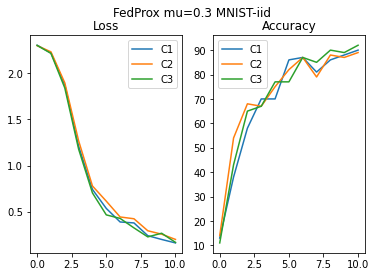

In [11]:
plot_acc_loss("FedProx mu=0.3 MNIST-iid", loss_hist_FP_iid, acc_hist_FP_iid)

### Conclusion and comparison

We notice that with both aggregation strategies the model converges to a high value of accuracy (consider that we are working with 600 images only). In this case where we have iid dataset across clients, the accuracy of FedAvg and FedProx are comparable.

## 2. MNIST non-iid

We split MNIST using a non-iid sampling. We assign digits 012, 345, 6789 to the 3 different clients.

In [12]:
mnist_non_iid_train_dls, mnist_non_iid_test_dls = get_MNIST("non_iid",
    n_samples_train =200, n_samples_test=100, n_clients =3, 
    batch_size =25, shuffle =True)

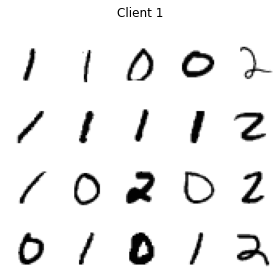

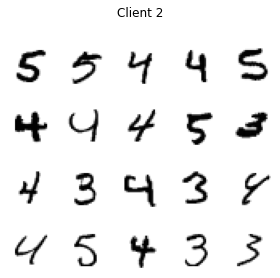

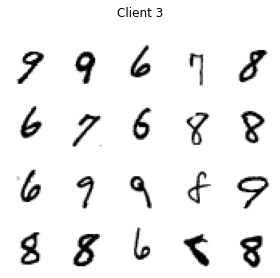

In [13]:
plot_samples(next(iter(mnist_non_iid_train_dls[0])), 0, "Client 1")
plot_samples(next(iter(mnist_non_iid_train_dls[1])), 0, "Client 2")
plot_samples(next(iter(mnist_non_iid_train_dls[2])), 0, "Client 3")

### Federated training with FedAvg

In [14]:
n_iter=20

model_f, loss_hist_FA_niid, acc_hist_FA_niid = FedProx( model_0, mnist_non_iid_train_dls, 
    n_iter, mnist_non_iid_test_dls, epochs=2, lr=0.1, mu=0)

Clients' weights: [0.30833333333333335, 0.29833333333333334, 0.3933333333333333]
====> i: 0 Loss: 2.3035332373778026 Server Test Accuracy: 10.427631578947368
====> i: 1 Loss: 2.21211057305336 Server Test Accuracy: 33.190873119781216
====> i: 2 Loss: 1.8929767590761184 Server Test Accuracy: 49.58899217363475
====> i: 3 Loss: 1.5228147757053376 Server Test Accuracy: 52.6654447062931
====> i: 4 Loss: 1.0361663792530695 Server Test Accuracy: 70.98690029385239
====> i: 5 Loss: 0.7790966289242108 Server Test Accuracy: 79.04630720665676
====> i: 6 Loss: 0.6598373493552208 Server Test Accuracy: 77.70309272351692
====> i: 7 Loss: 0.8474311022957166 Server Test Accuracy: 66.34223982427046
====> i: 8 Loss: 0.5172905304531257 Server Test Accuracy: 81.23853684792412
====> i: 9 Loss: 0.4401782628397147 Server Test Accuracy: 85.54868566524104
====> i: 10 Loss: 0.38579624344905217 Server Test Accuracy: 88.88877978528411
====> i: 11 Loss: 0.36501605952779453 Server Test Accuracy: 87.85310654330686
====

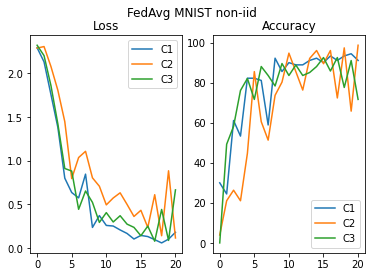

In [15]:
plot_acc_loss("FedAvg MNIST non-iid", loss_hist_FA_niid, acc_hist_FA_niid)

### Federated training with FedProx

In [16]:
n_iter=20

model_f, loss_hist_FP_niid, acc_hist_FP_niid = FedProx( model_0, mnist_non_iid_train_dls, 
    n_iter, mnist_non_iid_test_dls, epochs=2, lr=0.1, mu=.3)

Clients' weights: [0.30833333333333335, 0.29833333333333334, 0.3933333333333333]
====> i: 0 Loss: 2.303217958609263 Server Test Accuracy: 10.427631578947368
====> i: 1 Loss: 2.2002154767513273 Server Test Accuracy: 12.280956329463793
====> i: 2 Loss: 1.992260780533155 Server Test Accuracy: 55.3009368362864
====> i: 3 Loss: 1.5121528085072835 Server Test Accuracy: 57.165659276715836
====> i: 4 Loss: 1.32168463408947 Server Test Accuracy: 65.15926216868871
====> i: 5 Loss: 1.0472742260495822 Server Test Accuracy: 67.4146227924704
====> i: 6 Loss: 0.7838105999430021 Server Test Accuracy: 79.9137863315004
====> i: 7 Loss: 0.7433715458710988 Server Test Accuracy: 77.94839399493759
====> i: 8 Loss: 0.6137446504334609 Server Test Accuracy: 82.605466817957
====> i: 9 Loss: 0.506193338384231 Server Test Accuracy: 83.4904570713683
====> i: 10 Loss: 0.6771382251381874 Server Test Accuracy: 77.22904847109483
====> i: 11 Loss: 0.5139055017133554 Server Test Accuracy: 83.73664935556137
====> i: 12 L

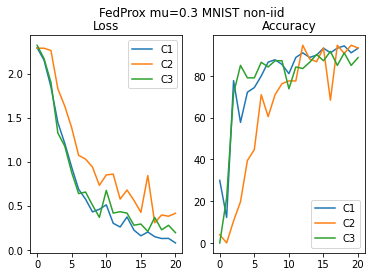

In [17]:
plot_acc_loss("FedProx mu=0.3 MNIST non-iid", loss_hist_FP_niid, acc_hist_FP_niid)

### Conclusion and comparison

Also in the non-iid case both aggregation methods yields good results in term of accuracy. FedProx is performing slighly better, since it is able to compensate for the heterogeneity of the data across the different clients

## Extra: Synthetic MNIST non-iid

We create a synthetic dataset of noisy digits with 3 channels and a different rotation for every channel. We split it across clients using a non-iid sampling, assigning digits 012, 345, 6789 to the 3 different clients.

In [18]:
C= {
     'n_samples_train': 200,
     'font':'Inconsolata',
     'tilt': [0, 45, 90],
     'std_tilt': 10, #std on the tilt,
     'seed':0
     }
C['n_samples']= int(1.5 * C['n_samples_train']) #20% more for the testing set

C1 =deepcopy(C)
C1['numbers'] = [0, 1, 2]

C2=deepcopy(C)
C2['numbers'] = [3, 4, 5]

C3=deepcopy(C)
C3['numbers']= [6, 7, 8, 9]

clients = [C1, C2, C3]

In [19]:
from create_synthetic_MNIST_datasets import get_synth_MNIST
custom_mnist_train, custom_mnist_test = get_synth_MNIST(
    clients, batch_size =10)

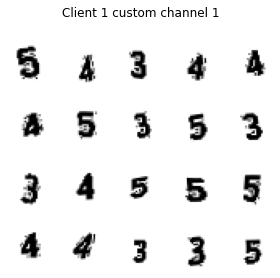

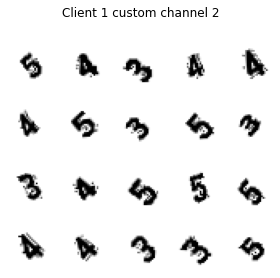

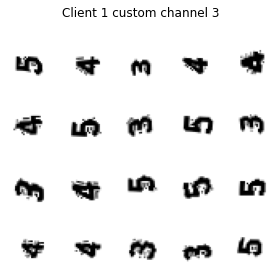

In [20]:
custom_mnist_train[1].dataset.plot_samples(0, "Client 1 custom channel 1")
custom_mnist_train[1].dataset.plot_samples(1, "Client 1 custom channel 2")
custom_mnist_train[1].dataset.plot_samples(2, "Client 1 custom channel 3")

In [21]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet -> 
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

model_1 = CNN()

### Federated training with FedAvg

In [22]:
n_iter=20

model_f, loss_hist_FA_niid, acc_hist_FA_niid = FedProx( model_1, custom_mnist_train, 
    n_iter, custom_mnist_test, epochs=2, lr=0.1, mu=0)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3024017016092935 Server Test Accuracy: 4.666666666666666
====> i: 1 Loss: 2.278077443440755 Server Test Accuracy: 21.333333333333332
====> i: 2 Loss: 2.1554079055786133 Server Test Accuracy: 43.99999999999999
====> i: 3 Loss: 1.7090081373850503 Server Test Accuracy: 49.0
====> i: 4 Loss: 1.3419753313064575 Server Test Accuracy: 59.33333333333333
====> i: 5 Loss: 0.9897036751111348 Server Test Accuracy: 64.66666666666666
====> i: 6 Loss: 0.9147616028785706 Server Test Accuracy: 61.666666666666664
====> i: 7 Loss: 1.0686317880948384 Server Test Accuracy: 49.666666666666664
====> i: 8 Loss: 0.850894272327423 Server Test Accuracy: 67.66666666666667
====> i: 9 Loss: 1.2260279854138691 Server Test Accuracy: 48.33333333333333
====> i: 10 Loss: 1.2638668616612752 Server Test Accuracy: 56.666666666666664
====> i: 11 Loss: 0.7759116788705189 Server Test Accuracy: 75.0
====> i: 12 Loss: 0.75407453378

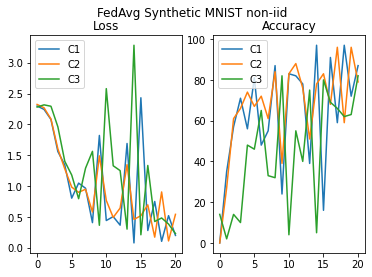

In [23]:
plot_acc_loss("FedAvg Synthetic MNIST non-iid", loss_hist_FA_niid, acc_hist_FA_niid)

### Federated training with FedProx

In [24]:
n_iter=20

model_f, loss_hist_FP_niid, acc_hist_FP_niid = FedProx( model_1, custom_mnist_train, 
    n_iter, custom_mnist_test, epochs=2, lr=0.1, mu=.3)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3024017810821533 Server Test Accuracy: 4.666666666666666
====> i: 1 Loss: 2.2907386620839434 Server Test Accuracy: 10.666666666666666
====> i: 2 Loss: 2.2279356320699053 Server Test Accuracy: 14.0
====> i: 3 Loss: 2.0604081948598223 Server Test Accuracy: 33.33333333333333
====> i: 4 Loss: 1.7148201862970986 Server Test Accuracy: 44.99999999999999
====> i: 5 Loss: 1.278675595919291 Server Test Accuracy: 59.0
====> i: 6 Loss: 1.290686011314392 Server Test Accuracy: 57.33333333333333
====> i: 7 Loss: 1.0084471503893533 Server Test Accuracy: 64.33333333333333
====> i: 8 Loss: 1.074092169602712 Server Test Accuracy: 59.0
====> i: 9 Loss: 0.8918289939562479 Server Test Accuracy: 63.99999999999999
====> i: 10 Loss: 0.7965412537256875 Server Test Accuracy: 71.33333333333333
====> i: 11 Loss: 0.7158505916595459 Server Test Accuracy: 68.66666666666666
====> i: 12 Loss: 0.6338446140289307 Server Test

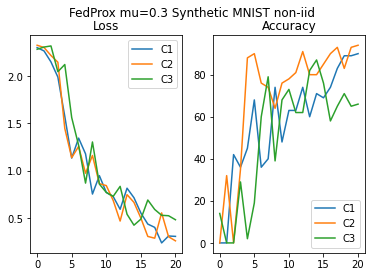

In [25]:
plot_acc_loss("FedProx mu=0.3 Synthetic MNIST non-iid", loss_hist_FP_niid, acc_hist_FP_niid)